## Context
This notebook will help me gain some experience in using machine learning / data analysis tools whilst on a topic that I enjoy. Taking data from MyAnimeList, https://www.kaggle.com/datasets/azathoth42/myanimelist?select=users_cleaned.csv I will:

- Perform some exploratoy data anaylsis EDA - see if I find anything interesting.
- Using collaborative filtering as a first iteration to recommend anime shows.
- Dive into more advanced techniques such as single value decomp 

Along the way, I'll be making mistakes and picking up new DS/ML techniques to resolve this mistakes and continue to docuement it in this notebook.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import surprise as sp
import time
print("Setup Complete")

Setup Complete


In [2]:
UsersDF = pd.read_csv('./data/full/users_cleaned.csv')
AnimesDF = pd.read_csv('./data/full/anime_cleaned.csv')
ScoresDF = pd.read_csv('./data/full/animelists_cleaned.csv')

In [3]:
AnimesDF.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


Using this to get a count of values https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173

Text(0.5, 1.0, 'Anime Genre')

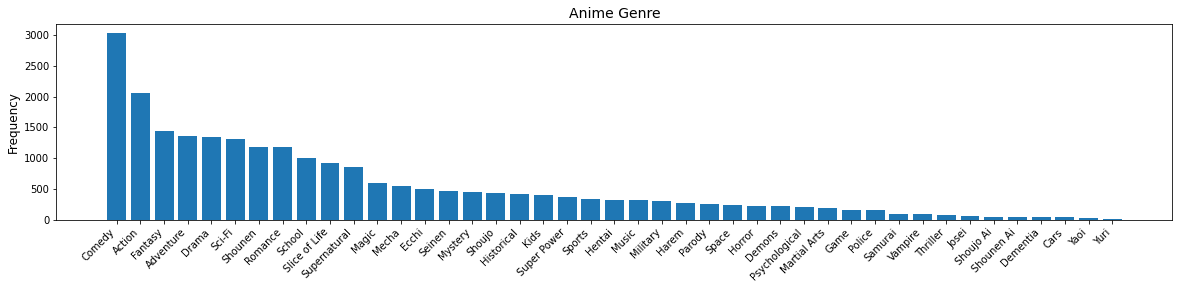

In [4]:
def turn_string_into_list(list_):
    return [x.strip() for x in list_.split(',')]

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

AnimesDF_without_na_genre = AnimesDF['genre'].dropna()
flattened = AnimesDF_without_na_genre.apply(turn_string_into_list)


fig, ax = plt.subplots(figsize = (20,4))
ax.bar(to_1D(flattened).value_counts().index,
        to_1D(flattened).value_counts().values)
fig.autofmt_xdate(rotation=45)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Anime Genre", size = 14)

In [5]:
to_1D(flattened).value_counts()

Comedy           3021
Action           2051
Fantasy          1441
Adventure        1355
Drama            1338
Sci-Fi           1318
Shounen          1182
Romance          1177
School           1004
Slice of Life     927
Supernatural      860
Magic             604
Mecha             543
Ecchi             506
Seinen            470
Mystery           454
Shoujo            440
Historical        425
Kids              406
Super Power       367
Sports            338
Hentai            331
Music             329
Military          312
Harem             276
Parody            267
Space             247
Horror            227
Demons            223
Psychological     206
Martial Arts      193
Game              168
Police            155
Samurai           102
Vampire           100
Thriller           79
Josei              67
Shoujo Ai          56
Shounen Ai         55
Dementia           47
Cars               41
Yaoi               28
Yuri               10
dtype: int64

What about correlation between the genres?

In [6]:
flattened_expanded = flattened.apply(pd.Series)

In [7]:
keys = to_1D(flattened).value_counts().keys()
def boolean_df(genres_lists, unique_genres):
# Create empty dict
    bool_dict = {}
    # Loop through all the genres
    for i, item in enumerate(unique_genres):
        # Apply boolean mask
        bool_dict[item] = genres_lists.apply(lambda x: item in x)            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

bool_df = boolean_df(flattened, keys)

bool_corr = bool_df.corr(method="pearson")

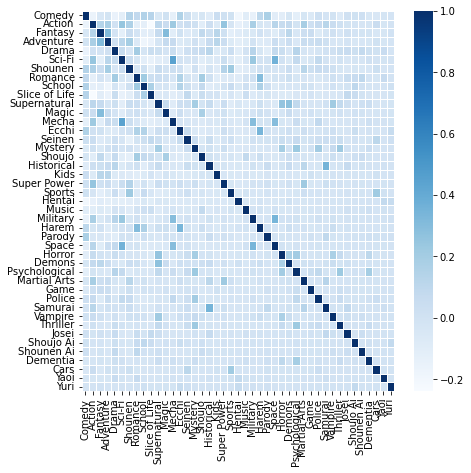

In [8]:
fig, ax = plt.subplots(figsize = (7,7))
sns.heatmap(bool_corr, cmap = "Blues", linewidths=1, xticklabels=True, yticklabels=True)
plt.xticks(rotation=90)
plt.show()

## Similar Item Recommender

The main goal here is to help a user who take really enjoyed a show and would like to watch more shows similar to it.

In [9]:
ScoresDF.head(10)

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN
5,karthiga,210,161,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:57:06,NaN
6,karthiga,232,70,0000-00-00,0000-00-00,6,2,NaN,0,2013-03-09 17:24:42,NaN
7,karthiga,233,78,0000-00-00,0000-00-00,6,2,NaN,0,2013-03-10 05:29:44,NaN
8,karthiga,249,167,0000-00-00,0000-00-00,8,2,NaN,0,2013-03-19 16:04:46,NaN
9,karthiga,269,366,0000-00-00,0000-00-00,10,2,NaN,0,2013-03-03 09:39:23,NaN


Let's keep it simple and extract the columns that I need. (The ScoresDF is a pretty big dataset)

In [10]:
ScoresDF_lite = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]
ScoresDF_lite

,username,anime_id,my_score,my_status
0,karthiga,21,9,1
1,karthiga,59,7,2
2,karthiga,74,7,2
3,karthiga,120,7,2
4,karthiga,178,7,2
...,...,...,...,...
31284025,Yokonightcore,15611,9,1
31284026,Yokonightcore,27815,9,1
31284027,wargod,5945,8,2
31284028,JMc_SetoKai_LoVe,1316,9,2


According to the dataset description https://www.kaggle.com/datasets/azathoth42/myanimelist?select=users_cleaned.csv:
- 1: watching 
- 2: completed 
- 3: on hold 
- 4: dropped 
- 6: plan to watch
  

In [11]:
AnimeDF_name_only = AnimesDF[['anime_id', 'title']]

In [12]:
ScoresDF_lite_with_names = ScoresDF_lite.merge(AnimeDF_name_only, left_on='anime_id', right_on='anime_id')
ScoresDF_lite_with_names

,username,anime_id,my_score,my_status,title
0,karthiga,21,9,1,One Piece
1,Damonashu,21,10,1,One Piece
2,bskai,21,8,1,One Piece
3,Slimak,21,10,1,One Piece
4,MistButterfly,21,0,1,One Piece
...,...,...,...,...,...
31284025,animekanji,37896,0,1,Ling Yu 6th Season
31284026,AnimeKhor,37896,0,6,Ling Yu 6th Season
31284027,FeliX_,37620,0,6,CMFU Xueyuan: Shenshi Ji Jijian
31284028,gasparsousa,37620,0,6,CMFU Xueyuan: Shenshi Ji Jijian


I think it is still useful to keep all my_status values. I probably wouldn't want to recommend an anime to a user that already has the anime added to their list.

In [13]:
# Uncomment this if you need to recalculate the df

scores_by_animeid = ScoresDF_lite_with_names.pivot_table(index='username', columns='title', values='my_score')
scores_by_animeid

title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,.hack//Liminality,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
username,,,,,,,,,,,,,,,,,,,,,
----phoebelyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
---L-AND-AME-4EV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--AnimeBoy--,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--Etsuko--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--FallenAngel--,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,9.0,9.0,8.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzshinzozz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zzvl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
zzz275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This takes a really long time.
One more interesting thought is that the best information gained of a particular user will be for a user to mark something really out of the ordinary. 
e.g. a user liking a show from the top 10, will lead to similarity scores of people liking top 10 shows. We will then recommend shows that are in the top 10, increasing the simularity scores of people liking top 10 shows. This will feedback loop into recommender suggesting only popular shows. Is this akin to local minima?

In [14]:
# Uncomment this if you need to recalculate the df
#anime_correlation = scores_by_animeid.corr(method='pearson')
#anime_correlation.to_csv('pearson_model.csv')

anime_correlation = pd.read_csv('pearson_model.csv')
anime_correlation

,title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
0,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",1.000000,0.761486,0.667558,-0.144841,0.544366,1.0,0.423505,0.378197,0.415617,...,0.451116,0.220825,0.390963,0.276203,NaN,0.318917,0.410028,0.440112,0.462676,0.270491
1,"""Bungaku Shoujo"" Memoire",0.761486,1.000000,0.750375,0.596636,0.620253,1.0,0.522055,0.448751,0.447011,...,0.428171,0.158142,0.424480,0.310737,NaN,0.309604,0.394492,0.429988,0.437890,0.275388
2,"""Bungaku Shoujo"" Movie",0.667558,0.750375,1.000000,0.684653,0.506488,1.0,0.405750,0.275404,0.314210,...,0.397856,0.193061,0.445828,0.317673,NaN,0.302128,0.352872,0.379855,0.375990,0.243901
3,"""Eikou Naki Tensai-tachi"" Kara no Monogatari",-0.144841,0.596636,0.684653,1.000000,1.000000,NaN,0.354857,0.387813,0.529335,...,NaN,NaN,0.666667,0.326080,NaN,0.187741,0.128340,0.399453,-0.132389,0.455160
4,"""Eiyuu"" Kaitai",0.544366,0.620253,0.506488,1.000000,1.000000,NaN,0.342372,0.145927,0.278976,...,0.686172,0.319932,0.189962,0.359987,NaN,0.316421,0.314322,0.474955,0.390338,0.328052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6663,xxxHOLiC,0.318917,0.309604,0.302128,0.187741,0.316421,NaN,0.420635,0.358055,0.381232,...,0.405780,0.329244,0.435485,0.357685,-1.317011e-01,1.000000,0.761127,0.656465,0.659535,0.260327
6664,xxxHOLiC Kei,0.410028,0.394492,0.352872,0.128340,0.314322,NaN,0.483009,0.416532,0.435048,...,0.467881,0.417986,0.431205,0.312047,-3.015113e-01,0.761127,1.000000,0.692215,0.783332,0.242532
6665,xxxHOLiC Movie: Manatsu no Yoru no Yume,0.440112,0.429988,0.379855,0.399453,0.474955,NaN,0.516949,0.490880,0.496508,...,0.521399,0.404712,0.426306,0.330117,-3.711348e-01,0.656465,0.692215,1.000000,0.680509,0.268535
6666,xxxHOLiC Shunmuki,0.462676,0.437890,0.375990,-0.132389,0.390338,NaN,0.471790,0.430899,0.465932,...,0.497103,0.455525,0.390910,0.327031,6.409876e-17,0.659535,0.783332,0.680509,1.000000,0.252541


This is a bit DIY but let's say I want to find out similar shows to my childhood favourite: "Detective Conan"

In [15]:
AnimesDF[AnimesDF['title'] == "Detective Conan"]

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
5896,235,Detective Conan,Case Closed,名探偵コナン,Meitantei Conan,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,Saturdays at 18:00 (JST),"{'Adaptation': [{'mal_id': 1061, 'type': 'mang...","Yomiuri Telecasting, Animax, YTV, TMS-Kyokuchi...","Funimation, Crunchyroll",TMS Entertainment,"Adventure, Mystery, Comedy, Police, Shounen","['#01: ""Mune ga Dokidoki (胸がドキドキ)"" by the High...","['#01: ""Step by Step"" by Ziggy (eps 1-26)', '#...",25.0,1996.0


In [16]:

anime_correlation[["title", "Detective Conan"]].sort_values(by="Detective Conan",ascending=False).head(20)


,title,Detective Conan
3316,Lalala Lala-chan: Patapata Daisensou,1.000000
4545,Peace Shitenchou,1.000000
1220,Diary,1.000000
6393,Xia Lan,1.000000
937,Clock Lock Works,1.000000
655,Boku wa Shitteru yo.,1.000000
6475,Yong Zhe Da Mao Xian 2nd Season,1.000000
3017,Kinyoubi no Yakusoku,1.000000
5709,Taka no Tsume x Megane Super,1.000000
3172,Kubbe PV Full ver.,1.000000


For conceptual understanding on what these Pearson correlation coefficient means...
If you were to imagine a graph where the axis are two different anime shows ("anime-space"). If we plot all the users inside this space, and perform a line of best fit on it, the r value describes how well correlated the two anime shows are.
Typically the values are between -1 <= r <= 1
- r=1 strongly positively correlated (if a user likes show A then, user likes show B aswell)
- r=0 uncorrelated
- r=1 strongly negatively correlated (if a user likes show A then, user dislikes show B)

Wait... these values are not correct

In [17]:
ScoresDF_lite_with_names[ScoresDF_lite_with_names['title'] == "Lalala Lala-chan" ]


,username,anime_id,my_score,my_status,title
31272315,arremakeone,36549,1,4,Lalala Lala-chan
31272316,axios1331,36549,0,1,Lalala Lala-chan
31272317,Exxorn,36549,0,6,Lalala Lala-chan
31272318,Azurii,36549,0,6,Lalala Lala-chan
31272319,Amitte_Sukku,36549,0,6,Lalala Lala-chan


There might be some funky stuff going on with the score==0

<BarContainer object of 11 artists>

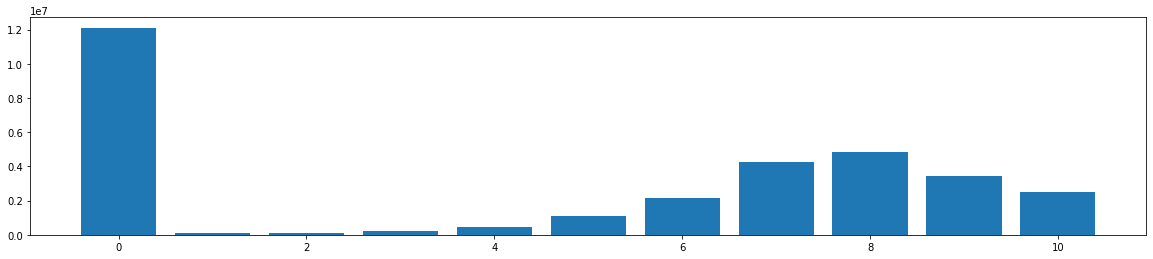

In [18]:
fig, ax = plt.subplots(figsize = (20,4))
ax.bar(ScoresDF_lite_with_names['my_score'].value_counts().index,
        ScoresDF_lite_with_names['my_score'].value_counts().values)


In [19]:
ScoresDF_lite_with_names[(ScoresDF_lite_with_names['title'] == "Detective Conan") & (ScoresDF_lite_with_names['my_score'] == 0)]


,username,anime_id,my_score,my_status,title
1935462,Slimak,235,0,1,Detective Conan
1935463,MistButterfly,235,0,3,Detective Conan
1935467,Sakurei,235,0,3,Detective Conan
1935469,ShinyShinigami,235,0,6,Detective Conan
1935482,ButterflyBoi,235,0,1,Detective Conan
...,...,...,...,...,...
1949716,HoneyToastAddict,235,0,1,Detective Conan
1949719,realFailix,235,0,4,Detective Conan
1949721,JuviaLockser,235,0,1,Detective Conan
1949722,Maiz94,235,0,1,Detective Conan


Score of 0 should not happen. MyAnimeList doesn't let to set the score to be 0 - the minimum is 1.

In [20]:
ScoresDF_lite_with_names_no_0_score = ScoresDF_lite_with_names[ScoresDF_lite_with_names['my_score'] > 0]
#scores_no_0_by_animeid = ScoresDF_lite_with_names_no_0_score.pivot_table(index='username', columns='title', values='my_score')
#anime_correlation_no_0 = scores_no_0_by_animeid.corr(method='pearson')
#anime_correlation_no_0.to_csv('pearson_model_no_zero.csv')

anime_correlation_no_0 = pd.read_csv('pearson_model_no_zero.csv')
anime_correlation_no_0


,title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eikou Naki Tensai-tachi"" Kara no Monogatari","""Eiyuu"" Kaitai","""Parade"" de Satie",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,...,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
0,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",1.000000,0.713538,0.631529,NaN,4.522489e-01,NaN,0.443324,0.356166,0.436534,...,0.538044,0.366292,0.344197,0.284043,NaN,0.318660,0.268127,0.373363,3.503581e-01,0.419694
1,"""Bungaku Shoujo"" Memoire",0.713538,1.000000,0.733710,NaN,3.832164e-01,NaN,0.408565,0.390416,0.429300,...,0.531728,0.633333,0.318005,0.375907,NaN,0.327733,0.284336,0.379452,3.664358e-01,0.306056
2,"""Bungaku Shoujo"" Movie",0.631529,0.733710,1.000000,NaN,3.502271e-01,NaN,0.369961,0.223673,0.339014,...,0.410075,-0.058597,0.331975,0.391351,NaN,0.277199,0.253305,0.314491,3.040379e-01,0.345320
3,"""Eikou Naki Tensai-tachi"" Kara no Monogatari",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"""Eiyuu"" Kaitai",0.452249,0.383216,0.350227,NaN,1.000000e+00,NaN,0.276414,0.062576,0.164135,...,0.594235,-1.000000,0.635107,-0.524217,NaN,0.221199,0.108454,0.153639,-1.738516e-16,0.553931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,xxxHOLiC,0.318660,0.327733,0.277199,NaN,2.211988e-01,NaN,0.357343,0.287104,0.359229,...,0.347760,0.337016,0.322669,0.319948,NaN,1.000000,0.763594,0.612772,6.407929e-01,0.354263
6594,xxxHOLiC Kei,0.268127,0.284336,0.253305,NaN,1.084539e-01,NaN,0.368991,0.283662,0.373312,...,0.402909,0.510176,0.370473,0.307706,NaN,0.763594,1.000000,0.617541,7.070609e-01,0.331492
6595,xxxHOLiC Movie: Manatsu no Yoru no Yume,0.373363,0.379452,0.314491,NaN,1.536387e-01,NaN,0.439786,0.371300,0.427431,...,0.528823,0.408434,0.322051,0.317989,NaN,0.612772,0.617541,1.000000,6.336485e-01,0.415704
6596,xxxHOLiC Shunmuki,0.350358,0.366436,0.304038,NaN,-1.738516e-16,NaN,0.490389,0.296309,0.391414,...,0.446028,0.624343,0.372902,0.408231,NaN,0.640793,0.707061,0.633649,1.000000e+00,0.351463


In [21]:
anime_correlation_no_0[["title", "Detective Conan"]].sort_values(by="Detective Conan",ascending=False).head(20)

,title,Detective Conan
3043,Kobo-chan,1.0
4561,Pittanko! Nekozakana,1.0
3904,Morimori Shima no Mogu to Perol,1.0
4481,Panpaka Pants Movie: Bananan Oukoku no Hihou,1.0
1199,Devilman Memorial,1.0
5877,To Be Heroine,1.0
1156,Detective Conan,1.0
1108,Dappys,1.0
1085,Damen&#039;s Walker,1.0
2150,Happy Jozy,1.0


These values do not look good.
I think there may be some problem with users that rate only a handful (less than 10 ratings). This is going to skew the dataset

In [22]:
UsersRatedPerAnime = ScoresDF_lite_with_names_no_0_score['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
UsersRatedPerAnime

,anime_id,number_of_users
0,1535,68999
1,20,52938
2,1575,52565
3,11757,52032
4,16498,51805
...,...,...
6593,36856,1
6594,16303,1
6595,33325,1
6596,33085,1


In [23]:
AnimesRatedPerUser = ScoresDF_lite_with_names_no_0_score['username'].value_counts().reset_index().rename(columns={"username": "number_of_animes", "index": "username"})
AnimesRatedPerUser

,username,number_of_animes
0,_thiagobrisolla,3785
1,misterferrari,3442
2,Shouichirou,3439
3,SakataYusuke,3383
4,Kannei,3285
...,...,...
106396,ZashShin,1
106397,hanible_fhyusa,1
106398,BakagamiD,1
106399,GrizzlyNA,1


I already have lots of data of the Scores. I don't need users that have only rated a small number of anime. I feel wary of keeping user data with lack of ratings. It will pollute the associations between animes when I start to build the correlation matrix.

This point draws a lot of similarities to the Cold Start problem. It's really hard to recommend anime to a user when you do not have any data about them. 
If a user 1 in the data set only put one rating for anime A, and a new user filters to user 1 because they happened to rate anime A aswell, there is nothing to recommend. There are ways to deal with to like using recommender for popular shows.


By doing an inner join merge of scoresDF i should be able to filter.

In [24]:
UserRatedsPerAnimeNice = UsersRatedPerAnime[UsersRatedPerAnime['number_of_users'] > 10]
AnimesRatedPerUserNice = AnimesRatedPerUser[AnimesRatedPerUser['number_of_animes'] > 10]

ScoresDFFilteredNice = pd.merge(ScoresDF_lite_with_names_no_0_score, AnimesRatedPerUserNice, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFFilteredNice = pd.merge(ScoresDFFilteredNice, UserRatedsPerAnimeNice, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')


In [25]:
AnimesRatedPerUserNice.shape

(97754, 2)

In [26]:
ScoresDFFilteredNice = ScoresDFFilteredNice[['username', 'anime_id', 'my_score', 'title']]

In [27]:
#scoresByAnimeFiltered = ScoresDFFilteredNice.pivot_table(index='username', columns='title', values='my_score')
#animeCorrelation = scoresByAnimeFiltered.corr(method='pearson')
#animeCorrelation.to_csv('pearson_model_nice_20.csv')

animeCorrelation = pd.read_csv('pearson_model_nice_20.csv')
animeCorrelation

,title,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eiyuu"" Kaitai",.hack//G.U. Returner,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,gdMen,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Shunmuki,ēlDLIVE
0,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",1.000000,0.713538,0.631529,4.522489e-01,0.443324,0.356166,0.436534,0.431122,0.580864,...,0.482934,0.538044,0.366292,0.344197,0.284043,0.318660,0.268127,0.373363,3.503581e-01,0.419694
1,"""Bungaku Shoujo"" Memoire",0.713538,1.000000,0.733710,3.832164e-01,0.408565,0.390416,0.429300,0.463195,0.591806,...,0.462249,0.531728,0.633333,0.318005,0.375907,0.327733,0.284336,0.379452,3.664358e-01,0.306056
2,"""Bungaku Shoujo"" Movie",0.631529,0.733710,1.000000,3.502271e-01,0.369961,0.223673,0.339014,0.428134,0.531802,...,0.416109,0.410075,-0.058597,0.331975,0.391351,0.277199,0.253305,0.314491,3.040379e-01,0.345320
3,"""Eiyuu"" Kaitai",0.452249,0.383216,0.350227,1.000000e+00,0.276414,0.062576,0.164135,0.398839,0.620221,...,0.399653,0.594235,-1.000000,0.635107,-0.524217,0.221199,0.108454,0.153639,-1.738516e-16,0.553931
4,.hack//G.U. Returner,0.443324,0.408565,0.369961,2.764136e-01,1.000000,0.577845,0.701867,0.575668,0.574447,...,0.423454,0.525463,0.829952,0.508666,0.420831,0.357343,0.368991,0.439786,4.903890e-01,0.514450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5926,xxxHOLiC,0.318660,0.327733,0.277199,2.211988e-01,0.357343,0.287104,0.359229,0.304927,0.333464,...,0.275510,0.347760,0.337016,0.322669,0.319948,1.000000,0.763454,0.612903,6.401383e-01,0.354263
5927,xxxHOLiC Kei,0.268127,0.284336,0.253305,1.084539e-01,0.368991,0.283662,0.373312,0.284045,0.433255,...,0.297387,0.402909,0.510176,0.370473,0.307706,0.763454,1.000000,0.617751,7.067436e-01,0.331492
5928,xxxHOLiC Movie: Manatsu no Yoru no Yume,0.373363,0.379452,0.314491,1.536387e-01,0.439786,0.371300,0.427431,0.409252,0.467104,...,0.403167,0.528823,0.408434,0.322051,0.317989,0.612903,0.617751,1.000000,6.334539e-01,0.415704
5929,xxxHOLiC Shunmuki,0.350358,0.366436,0.304038,-1.738516e-16,0.490389,0.296309,0.391414,0.417399,0.502504,...,0.354477,0.446028,0.624343,0.372902,0.408231,0.640138,0.706744,0.633454,1.000000e+00,0.351463


In [28]:
animeCorrelation[["title", "Detective Conan"]].sort_values(by="Detective Conan",ascending=False).head(20)

,title,Detective Conan
1067,Detective Conan,1.000000
2201,Huyao Xiao Hongniang: Nan Guo,0.977372
4672,Shi Xiong,0.940325
1383,Fantasista Stella,0.935513
4523,Satsujin Kippu wa Heart-iro,0.904748
3107,Machine Robo: Cronos no Dai Gyakushuu,0.902108
4117,Play Ball,0.872872
4577,Seishun Anime Zenshuu,0.866845
1318,Eiyuu Gaiden Mozaicka,0.862949
3441,Mitsuami no Kamisama,0.860613


The results show a bunch of Dragon ball related stuff which makes sense. 



## Evaluation of your model
What I have been doing to evaluate the list of animes returned is what seemed 'right' based on my prior knowledge of animes that are similar.

A better approach than this is to reserve some data to benchmark the predictions. In the DS/ML world there are many ways make use of this 'test data' to benchmark how well the predictions compare with the 'test data'.
A few examples here are:

In [29]:
ScoresDFFilteredNice.shape

(19125485, 4)

## Recommender - using the surprise library
The surprise is a python toolkit mainly for recommender systems. The logic of preparing correlations between shows/users, splitting the data and the top-k items are all supported (much better than me).

In [30]:
reader = sp.Reader(rating_scale=(1, 10))
data = sp.Dataset.load_from_df(ScoresDFFilteredNice[['username', 'title', 'my_score']], reader)

In [31]:
benchmark = []
# Iterate over all algorithms

algorithms = [sp.SVD(), sp.SVDpp(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]
#algorithms = [sp.SVD()]
print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = sp.model_selection.cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002A140988DC0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002A140988DC0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002A140988DC0> 



	DONE



C:\Users\Hansw\AppData\Local\Temp\ipykernel_22628\3098515505.py:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [35]:
# ## SAVING TRAINED MODEL
# from surprise import dump
# import os
# model_filename = "./model.pickle"
# print (">> Starting dump")
# # Dump algorithm and reload it.
# file_name = os.path.expanduser(model_filename)
# dump.dump(file_name, algo=algorithms[0])
# print (">> Dump done")
# print(model_filename)

>> Starting dump
>> Dump done
./model.pickle
